### image_shower.ipynb

In [1]:
import os
import pdb
import json
import PIL
from glob import glob
# from pipelines.video_action_recognition_config import get_cfg_defaults
# from attention_playground import make_transforms, load_annotation, loadvideo
import csv
import visualization_utils_custom as vis_utils
import imageio.v2 as imageio
from IPython import display
import random

dataset_path = '/mnt/tmp/frames/{}'
video_list = os.listdir(dataset_path.format(""))

# cfg = get_cfg_defaults()
# cfg.merge_from_file("./configuration/TubeR_CSN152_AVA21.yaml")

anno_path = '/home/nsml/assets/ava_{}_v21.json'
val_bbox_json = json.load(open(anno_path.format("val")))
train_bbox_json = json.load(open(anno_path.format("train")))


save_path = "./"
# os.makedir("/mnt/tmp/new_frames/")
# transforms=make_transforms("val", cfg)

train_video_frame_bbox, train_frame_keys_list = train_bbox_json["video_frame_bbox"], train_bbox_json["frame_keys_list"]
val_video_frame_bbox, val_frame_keys_list = val_bbox_json["video_frame_bbox"], val_bbox_json["frame_keys_list"]

train_video_frame_anno = train_bbox_json

val_frame_keys = [key for key in val_bbox_json]
train_frame_keys = [key for key in train_bbox_json]
frame_keys = val_frame_keys_list + train_frame_keys_list
val_video_frame_bbox.update(train_video_frame_bbox) # dictionary
frame_bbox = val_video_frame_bbox

frame_keys_dict = {}

"""
{vid_id:
    [key_frame of the video],
    ...
}

"""
for key in frame_keys:
    vid, frame_id = key.split(",")[0], int(key.split(",")[1])
    if not vid in frame_keys_dict.keys():
        frame_keys_dict[vid] = [frame_id]
    else:
        frame_keys_dict[vid].append(frame_id)
    frame_keys_dict[vid].sort()

# csv_path = '/home/nsml/assets/ava_{}_v2.1.csv'

# file = open(csv_path.format("val"))
# csvreader = csv.reader(file)
# rows = []
# for row in csvreader:
#     vid, keys, cls, instance = row[0], row[1], row[-2], row[-1]
#     bbox = row[2:6]

    
def read_label_map(label_map_path):

    item_id = None
    item_name = None
    items = {}
    
    with open(label_map_path, "r") as file:
        for line in file:
            line.replace(" ", "")
            if line == "item{":
                pass
            elif line == "}":
                pass
            elif "id:" in line:
                item_id = int(line.split(":", 1)[1].strip())
            elif "name" in line:
                item_name = line.split(":", 1)[1].replace("'", "").strip()

            if item_id is not None and item_name is not None:
                items[item_id] = item_name
                item_id = None
                item_name = None
            items[81] = "happens"

    return items

items = read_label_map("../assets/ava_action_list_v2.1.pbtxt")

def crop_normalize(img, bboxes):
    imgs = list()
    for box in bboxes:
        h, w = img.size
        left, top, right, bottom = w * box[0], h * box[1], w * box[2], h * box[3]
        img.crop((left, top, right, bottom)).resize(128, 128)
        imgs.append()

    return imgs



def find_key_frame(vid, frame_id):
    for i, key_frame in enumerate(frame_keys_dict[vid]): # key_frame is sorted in ascending order
        if key_frame*30-27000 < frame_id:
            continue
        else:
            keyf_index = i
            break
    try:
        if (frame_keys_dict[vid][keyf_index]*30-27000 - frame_id) < (frame_id - (frame_keys_dict[vid][max(keyf_index-1, 0)]*30-27000)):
            return frame_keys_dict[vid][keyf_index]
        else: 
            return frame_keys_dict[vid][max(keyf_index-1, 0)]
    except:
        return frame_keys_dict[vid][0]


random_vid = random.randint(0,len(video_list)-1)

def img_along_(t):
    video = video_list[random_vid]
    # for video in video_list:
    video_frame_path = dataset_path.format(video)
    video_frame_list = sorted(glob(video_frame_path + '/*.jpg'))
    # for frame in video_frame_list:
    frame = video_frame_list[t]
    img = PIL.Image.open(video_frame_path + "/" + frame.split('/')[-1])
    w, h = img.size
    if w >= h:
        nh = 256
        nw = 256 * w / h
    else:
        nw = 256
        nh = 256 * h / w

    img = img.resize((int(nw), int(nh)))
    frame_id = int(frame[-10:-4])
    reference_key_frame = find_key_frame(video, frame_id)
    vid_keyf = video + "," + str(reference_key_frame).zfill(4)
    bboxes = frame_bbox[vid_keyf]["bboxes"]
    acts = frame_bbox[vid_keyf]["acts"]
    for i, coord in enumerate(bboxes):
        xmin, ymin, xmax, ymax = coord[0], coord[1], coord[2], coord[3]
        cat = [items[j+1] for j in acts[i]]
        vis_utils.draw_bounding_box_on_image(
            img, ymin, xmin, ymax, xmax,
            color = 'Green',
            display_str_list=cat,
            use_normalized_coordinates=True
        )
        # display(img)
    return img

In [ ]:
ims = []
for t in range(1000,1500): # this decides video length
    ims.append(img_along_(t))

imageio.mimsave('./temp.gif', ims, duration=0.06)

display.Image("./temp.gif")

In [4]:
import numpy as np
import itertools

train_co_occurence_map = np.zeros((80,80))
val_co_occurence_map = np.zeros((80,80))

for key in train_frame_keys_list:
    instance_list = train_video_frame_bbox[key]['acts']
    for instance in instance_list:
        # instance: [m, n, o]
        for i, j in itertools.product(instance, instance):
            train_co_occurence_map[i, j] += 1

for key in val_frame_keys_list:
    instance_list = val_video_frame_bbox[key]['acts']
    for instance in instance_list:
        # instance: [m, n, o]
        for i, j in itertools.product(instance, instance):
            val_co_occurence_map[i, j] += 1

def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

train_co_occurence_map = sigmoid(train_co_occurence_map)
val_co_occurence_map = sigmoid(val_co_occurence_map)


output_labels = []
for gpu_num in range(4):
    detection = '/mnt/video-nfs5/users/jinsung/results/tubelet-transformer/eval/tmp3/{}.txt'.format(gpu_num)
    with open(detection) as f:
        for line in f.readlines():
            # img_id = line.split(' ')[0]
            annotation = [float(n) for n in line.split('[')[1].split(']')[0].split(',')]
            multi_hot_obj_label = annotation[4:-1]
            output_labels.append([i for i, e in enumerate([k>0.6 for k in multi_hot_obj_label]) if e])


model_output_co_occurence_map = np.zeros((80,80))

for instance in output_labels:
    # instance: [m, n, o]
    if len(instance)!=0:
        for i, j in itertools.product(instance, instance):
            model_output_co_occurence_map[i, j] += 1
    else:
        pass


model_output_co_occurence_map = sigmoid(model_output_co_occurence_map)

Text(0.5, 1.0, 'model_output')

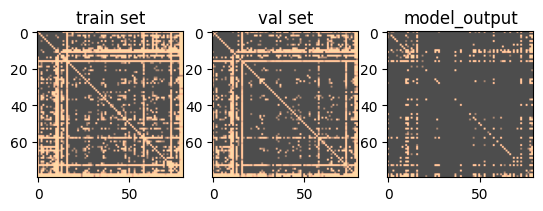

In [5]:
import matplotlib.pyplot as plt

%matplotlib inline
fig, axs = plt.subplots(ncols=3, nrows=1)
axs[0].imshow(train_co_occurence_map, cmap='copper', interpolation=None, alpha=.7)
axs[0].set_title("train set")
axs[1].imshow(val_co_occurence_map, cmap='copper', interpolation=None, alpha=.7)
axs[1].set_title("val set")
axs[2].imshow(model_output_co_occurence_map, cmap='copper', interpolation=None, alpha=.7)
axs[2].set_title("model_output")